# Almond Orchard Water Use 

## What we will do here
In this section we will propose a methodology to estimate Reference Evapotranspiration (ETref), Maximum crop or potential evapotranspiration (ETc) and actual evapotranspiration (ETa). There are ET products available, but they need to be tweeked to Almond cultivation or do not have the right temporal or spatial resolution. To compute actual evapotranspiration it could be worthwhile to consult thermal/ energy balance products in the future ([Example](https://www.usgs.gov/landsat-missions/landsat-collection-2-provisional-actual-evapotranspiration-science-product)). For now we follow on an optical based algortihm to get at least ETref, ETc, and potentially ETa for case study fields. We do this to get an idea of the necessary building blocks. Here a short definition of these terms:

* ETref (Reference Evapotranspiration): This is the evapotranspiration rate from a well-watered, uniform reference surface (typically grass or alfalfa). It reflects the climate demand (influenced by temperature, wind, humidity, radiation) and is used as a baseline for estimating crop water needs. The reference surface is a hypothetical grass reference crop with an assumed crop height of 0.12 m, a fixed surface resistance of 70 s/m and an albedo of 0.23. The reference surface closely resembles an extensive surface of green, well-watered grass of uniform height, actively growing and completely shading the ground. The fixed surface resistance of 70 s/m implies a moderately dry soil surface resulting from about a weekly irrigation frequency. [Click for full formula and explanation](https://www.weap21.org/webhelp/Mabia_Alg_ETRef.htm#:~:text=Reference%20crop%20evapotranspiration%20or%20reference,m%20and%20an%20albedo%20of)

* ETc (Crop Evapotranspiration): This is the potential water use of a specific crop under ideal (well-watered) conditions. It is calculated by multiplying ETref by crop-specific coefficients that account for canopy size, growth stage, and irrigation design.

* Actual ET: This is the real water loss from a crop under actual conditions, which may be lower than ETc due to water stress, disease, or poor irrigation.


```{figure} figures/methodology_evaporation.PNG
---
height: 300px
name: directive-fig
---
The methodology we use here is a simplified version of the one proposed by den Besten et al, 2020
```

## Snippets of TECHNICAL REPORT - Portugal Nuts
The report determines the water requirements of tree nut crops in the main production areas of Portugal

* The intensification of almond production in Portugal is a recent phenomenon, as the acreage of new intensive plantations has gone from less than 2.000 ha in 2014 to more than 26.000 ha in 2020. Irrigation is indispensable to achieve high productivity in Portugal. (maybe give a calculation)

* Methodology used: After determining ETc, the net irrigation requirements are computed based on the effective rainfall and the water
budget of the crop root zone. Such irrigation requirements are calculated for the different areas and for a period of 11 years over the last two decades to capture the temporal variability. They represent the net irrigation demand needed to achieve maximum production in an average year.

* Maximum Kc values are typically reached on July-August, ranging from 0.95 to 1.10. However, more recent data from California suggests that almond Kc maximum values of mature orchards irrigated with microsprinklers may reach values as high as 1.2 (Goldhamer & Girona, 2012). High Kc values, close to 1.2, have been also reported in Australia (Stevens et al., 2011). Higher Kc values are likely due to the increase in planting densities in recent plantations, larger tree canopies due to less annual pruning, and higher fruit loads. Additionally, more frequent soil wetting due to high-frequency irrigation can also increase direct soil surface evaporation which may also contribute to high Kc values. With this background, the almond crop coefficients used here are based on direct ETc field measurements conducted during 10 years in Córdoba, Spain, using a weighing lysimeter installed in 2009 (the only weighing lysimeter of almond in the world until recently), as reported in three consecutive doctoral theses (i.e., Espadafor, 2015; López-López, 2018 and Moldero, 2021).

```{figure} figures/crop_factors.PNG
---
height: 300px
name: directive-fig
---
Crop factors used
```
the optimal deficit irrigation program for almond should prioritize supplying the full ETc in the following periods:

1. Fruit set and early canopy growth (normally achieved if the winter had normal rainfall and the soil is fully charged at flowering)
2. Post-harvest period when the floral buds of the following season are formed. Normally, a month duration after harvest is considered minimum, then some water deficits may be applied later, as the end of the season approaches.
3. Severe water deficits should be always avoided; ETa should not be below 50% of ETc throughout the season.

```{figure} figures/almond_irrigation_requirement.PNG
---
height: 300px
name: directive-fig
---
70 percent canopy over orchard (CC=70%) (López-López et al., 2018)
```


## Reference evapotranspiration

Daily Reference ET (df_ETref) -- daily, 30 km (I think it is Penmann Monteith) data from: https://data.apps.fao.org/wapor/?lang=en for Rota Única Farm to start with


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os


# Load ETref
df_ETref = pd.read_csv(
    os.path.join('Data/Evaporation', 'Ref_ET.csv'),
    index_col=0,
    header=0,
    names=['ETref'],
    delimiter=';',
    decimal=','
)
df_ETref.index = pd.to_datetime(df_ETref.index)
df_ETref = df_ETref[~df_ETref.index.duplicated(keep='first')]

# Load Precipitation
df_prec = pd.read_csv(
    os.path.join('Data/Evaporation', 'CHIRPS_Daily_Precipitation.csv'),
    index_col=1,
    header=0
)
df_prec.index = pd.to_datetime(df_prec.index)
df_prec = df_prec.rename(columns={'precip_mm': 'Precip'})  # Optional: rename for clarity

df_prec = df_prec[~df_prec.index.duplicated(keep='first')]
df_prec = df_prec[['Precip']]

# Load NDVI
df_ndvi = pd.read_csv(
    os.path.join('Data/extended', 'NDVI_TimeSeries_PerFeature_ext_vc2.csv'),
    index_col=7,
    header=0
)
df_ndvi.index = pd.to_datetime(df_ndvi.index)
df_ndvi = df_ndvi.rename(columns={'NDVI_mean': 'NDVI'}) if 'NDVI_mean' in df_ndvi.columns else df_ndvi
df_ndvi = df_ndvi[['NDVI']] if 'NDVI' in df_ndvi.columns else df_ndvi.iloc[:, [0]]
df_ndvi = df_ndvi[~df_ndvi.index.duplicated(keep='first')]
df_ndvi = df_ndvi[['NDVI']]

# Merge all on the date index
df_merged = pd.concat([df_ETref, df_prec, df_ndvi], axis=1)

# Sort index (optional but tidy)
df_merged = df_merged.sort_index()

# interpolate NDVI
df_merged['NDVI'][df_merged['NDVI'] < 0.1] = np.nan
df_merged['NDVI'] = df_merged['NDVI'].interpolate()

# select focus
df_merged = df_merged['2018-01-01':'2025-01-01']

df_merged
# Final preview
print(df_merged.head())
print(df_merged.info())

            ETref    Precip      NDVI
2018-01-01    0.6   0.00000  0.203622
2018-01-02    0.6   0.00000  0.206655
2018-01-03    0.7   0.00000  0.209688
2018-01-04    0.6  14.90844  0.212722
2018-01-05    0.6   0.00000  0.215755
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2558 entries, 2018-01-01 to 2025-01-01
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ETref   2558 non-null   float64
 1   Precip  2558 non-null   float64
 2   NDVI    2558 non-null   float64
dtypes: float64(3)
memory usage: 79.9 KB
None


C:\Users\ici-1\AppData\Local\Temp\ipykernel_13428\3585435158.py:51: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_merged['NDVI'][df_merged['NDVI'] < 0.1] = np.nan


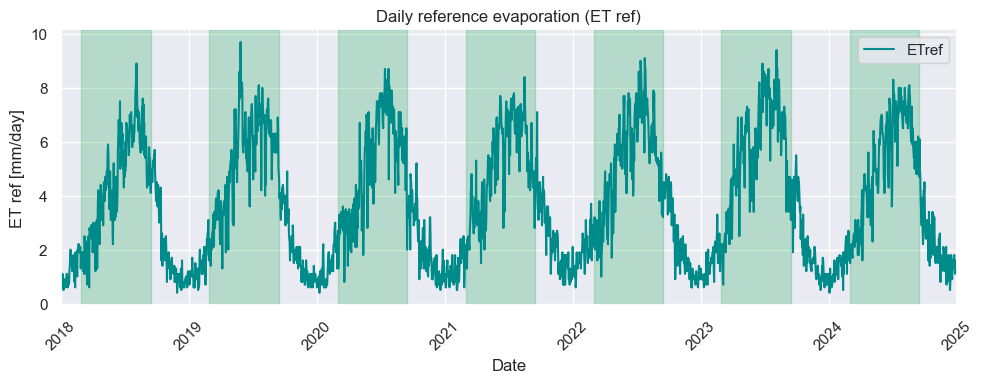

In [21]:
# === Plot NDVI time series with min/max around median ===
sns.set_theme()

fig, ax = plt.subplots(figsize=(10, 4))


df_merged['ETref'].plot(color='darkcyan', ax=ax)

# Loop through each year and color the background for March to September
for year in range(df_merged['ETref'].index.year.min(), df_merged['ETref'].index.year.max() + 1):
    start_date = pd.Timestamp(f'{year}-03-01')  # March 1st of the year
    end_date = pd.Timestamp(f'{year}-09-15')   # September 30th of the year
    ax.axvspan(start_date, end_date, color='mediumseagreen', alpha=0.3)

# Labels and legend
plt.title('Daily reference evaporation (ET ref)')
plt.xlabel('Date')
plt.ylabel('ET ref [mm/day]')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# === Show plot ===
plt.show()

## Precipitation and NDVI data

We got precipitation data from CHIRPS and NDVI data from S2 (this will can used for the Crop Factors at a next stage)

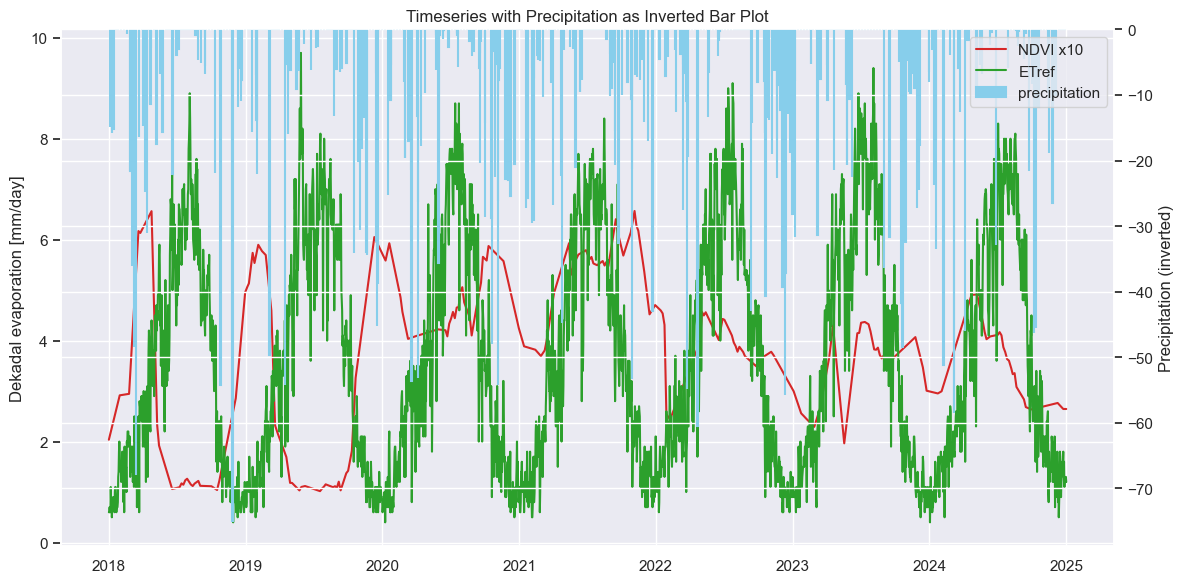

In [22]:
# === Plot NDVI time series with min/max around median ===
sns.set_theme()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Loop through each year and color the background for March to September
for year in range(df_merged.index.year.min(), df_merged.index.year.max() + 1):
    start_date = pd.Timestamp(f'{year}-03-01')  # March 1st of the year
    end_date = pd.Timestamp(f'{year}-09-15')   # September 30th of the year
    ax.axvspan(start_date, end_date, color='mediumseagreen', alpha=0.3)

# Line plots for 
ax1.plot(df_merged.index, df_merged['NDVI']*10, color='tab:red', label='NDVI x10')
ax1.plot(df_merged.index, df_merged['ETref'], color='tab:green', label='ETref')
ax1.set_ylabel('Dekadal evaporation [mm/day]')
# ax1.legend(loc='upper left')

# Secondary y-axis for Precipitation (plotted as a bar plot, top-down)
ax2 = ax1.twinx()
ax2.bar(df_merged.index, -df_merged['Precip'], color='skyblue', edgecolor='skyblue', linewidth=1.5, label='precipitation')
ax2.set_ylabel('Precipitation (inverted)')
# ax2.legend(loc='upper right')

# Optional: make sure the precipitation legend appears
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Timeseries with Precipitation as Inverted Bar Plot')
plt.tight_layout()
plt.show()

### Static Crop Factors

An example with static crop factors...

In [ ]:
# Define Kc values by month
kc_by_month = {
    1: 0.30,  2: 0.30,  3: 0.40,
    4: 0.60,  5: 0.80,  6: 0.90,
    7: 0.90,  8: 0.85,  9: 0.70,
    10: 0.50, 11: 0.30, 12: 0.30
}

# Add Kc values by mapping the month from the 'date' column
df_merged['Kc'] = df_merged.index.month.map(kc_by_month)

df_merged['ETc'] = df_merged['ETref'] * df_merged['Kc'] 
print(df_merged.head())

            ETref    Precip      NDVI   Kc   ETc
2018-01-01    0.6   0.00000  0.203622  0.3  0.18
2018-01-02    0.6   0.00000  0.206655  0.3  0.18
2018-01-03    0.7   0.00000  0.209688  0.3  0.21
2018-01-04    0.6  14.90844  0.212722  0.3  0.18
2018-01-05    0.6   0.00000  0.215755  0.3  0.18


C:\Users\ici-1\AppData\Local\Temp\ipykernel_4292\2378865283.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([abs(int(label)) for label in ax2.get_yticks()])


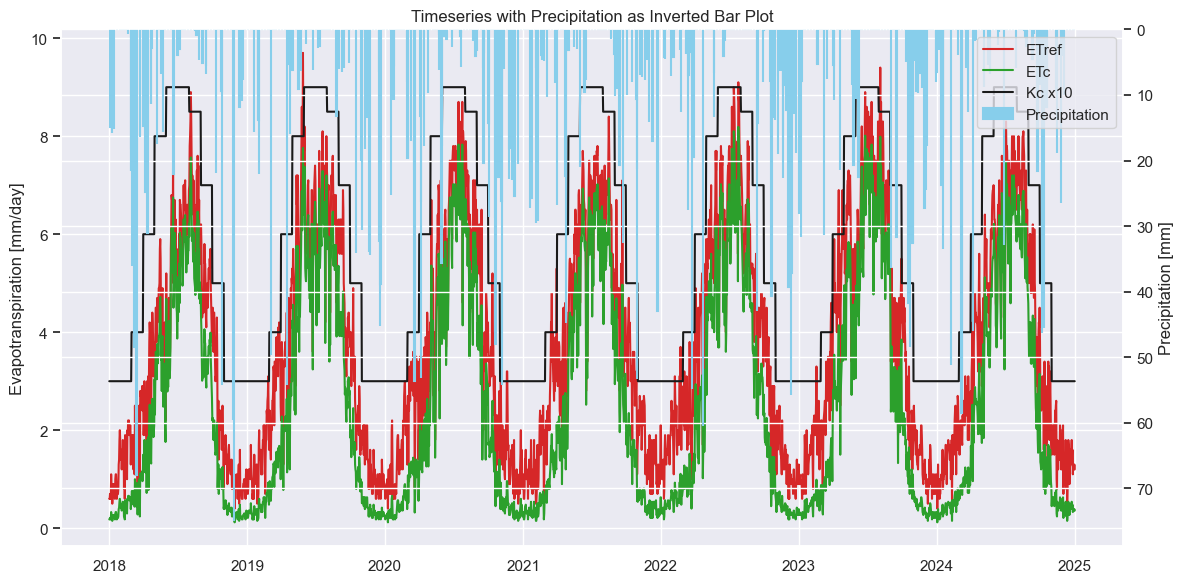

In [24]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gridlines go to the back
ax1.grid(True, zorder=0)
ax1.set_axisbelow(True)

# Secondary y-axis for Precipitation (top-down bar plot)
ax2 = ax1.twinx()
# Gridlines go to the back
ax2.grid(True, zorder=0)
ax2.set_axisbelow(True)

ax2.bar(df_merged.index, df_merged['Precip'], color='skyblue', edgecolor='skyblue', linewidth=1.5, label='Precipitation', zorder=1)

# Invert y-axis so bars go top-down, but show positive tick labels
ax2.invert_yaxis()
ax2.set_ylabel('Precipitation [mm]')
ax2.set_yticklabels([abs(int(label)) for label in ax2.get_yticks()])

# Line plots for ETref, ETc, Kc
ax1.plot(df_merged.index, df_merged['ETref'], color='tab:red', label='ETref', zorder=2)
ax1.plot(df_merged.index, df_merged['ETc'], color='tab:green', label='ETc', zorder=2)
ax1.plot(df_merged.index, df_merged['Kc']*10, color='k', label='Kc x10', zorder=2)
ax1.set_ylabel('Evapotranspiration [mm/day]')

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')



plt.title('Timeseries with Precipitation as Inverted Bar Plot')
plt.tight_layout()
plt.show()


### Flexible Crop Factors

Here we use the study of Portugal Nuts to get to flexible crop factors that can be used to calculate the potential Orchard Water Use.

In [30]:
import math

def calculate_etc(eto, cc, fw, month, F):
    """
    Calculate crop evapotranspiration (ETc) for almond orchards.

    Parameters:
    - eto: Reference evapotranspiration (ETo)
    - cc: Canopy cover (0-1 scale, e.g., 0.7 for 70%)
    - fw: Fraction of wet soil surface (typically 0.15)
    - month: Integer month (1=January, ..., 12=December)
    - F: Monthly fraction of rainy days (0-1)

    Returns:
    - etc: Crop evapotranspiration (ETc)
    - Kt: Transpiration coefficient
    - Kg: Wetted soil evaporation coefficient
    - Ks: Dry soil evaporation coefficient
    """

    # Check if within irrigation period (April to October)
    is_irrigation_period = 4 <= month <= 9

    # Kg component: evaporation from wetted soil surface
    if is_irrigation_period:
        intercepted_radiation_factor = 1.2
        Kg = 1.4 * 0.15 * math.exp(-1.6 * cc * intercepted_radiation_factor) * fw
    else:
        Kg = 0

    # Ks component: evaporation from dry soil surface
    if is_irrigation_period and eto > 0:
        Ks = (0.28 - (0.18 * cc) - (0.03 * eto) + (3.8 * F * (1 - F) / eto)) * (1 - fw)
    else:
        Ks = 0

    # Kt component: tree transpiration
    if month in [12, 1, 2]:  # Dormant period
        Kt = 0
    else:
        # Compute Kt peak based on canopy cover
        if 0.3 < cc < 0.5:
            Kt_peak = 1.5 * cc
        elif 0.5 <= cc < 0.8:
            Kt_peak = 0.75 + (cc - 0.5)
        else:
            Kt_peak = 0

        if month == 3:
            Kt = 0.5 * Kt_peak
        elif month in [4, 11]:
            Kt = 0.7 * Kt_peak
        elif month == 5:
            Kt = 0.9 * Kt_peak
        elif 6 <= month <= 10:
            Kt = Kt_peak
        else:
            Kt = 0

    # Final ETc calculation
    etc = eto * (Kt + Kg + Ks)
    return etc, Kt, Kg, Ks

In [26]:
# get rainy day fraction (F)
df_merged['Year'] = df_merged.index.year
df_merged['Month'] = df_merged.index.month

# Define rainy day threshold (e.g., 1 mm)
rain_threshold = 1.0

# Create a binary indicator for rainy days
df_merged['IsRainyDay'] = df_merged['Precip'] >= rain_threshold

# Group by year and month and calculate rainy day fraction
monthly_rainy_fraction = (
    df_merged.groupby(['Year', 'Month'])['IsRainyDay']
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'RainyDays', 'count': 'TotalDays'})
)
monthly_rainy_fraction['RainyDaysFraction'] = monthly_rainy_fraction['RainyDays'] / monthly_rainy_fraction['TotalDays']

original_index = df_merged.index  # Save current index
# Merge back into original dataframe
df_merged = df_merged.merge(
    monthly_rainy_fraction['RainyDaysFraction'],
    on=['Year', 'Month'],
    how='left'
)
df_merged.index = original_index  # Restore original index

print(df_merged.head())

            ETref    Precip      NDVI   Kc   ETc  Year  Month  IsRainyDay  \
2018-01-01    0.6   0.00000  0.203622  0.3  0.18  2018      1       False   
2018-01-02    0.6   0.00000  0.206655  0.3  0.18  2018      1       False   
2018-01-03    0.7   0.00000  0.209688  0.3  0.21  2018      1       False   
2018-01-04    0.6  14.90844  0.212722  0.3  0.18  2018      1        True   
2018-01-05    0.6   0.00000  0.215755  0.3  0.18  2018      1       False   

            RainyDaysFraction  
2018-01-01            0.16129  
2018-01-02            0.16129  
2018-01-03            0.16129  
2018-01-04            0.16129  
2018-01-05            0.16129  


In [32]:
# Example DataFrame
# Columns: ETo, Month, F (fraction of rainy days)
# Constants
cc = 0.7 # this may be turned flexible (maximum canopy cover)
fw = 0.15 # depends on irrigation type

# Apply row-wise
df_merged[['ETc_2', 'Kt', 'Kg', 'Ks']] = df_merged.apply(
    lambda row: pd.Series(calculate_etc(row['ETref'], cc, fw, row['Month'], row['RainyDaysFraction'])),
    axis=1
)

df_merged.head()




,ETref,Precip,NDVI,Kc,ETc,Year,Month,IsRainyDay,RainyDaysFraction,ETc_2,Kt,Kg,Ks,Kc_2
2018-01-01,0.6,0.00000,0.203622,0.3,0.18,2018,1,False,0.16129,0.0,0.0,0.0,0.0,0.0
2018-01-02,0.6,0.00000,0.206655,0.3,0.18,2018,1,False,0.16129,0.0,0.0,0.0,0.0,0.0
2018-01-03,0.7,0.00000,0.209688,0.3,0.21,2018,1,False,0.16129,0.0,0.0,0.0,0.0,0.0
2018-01-04,0.6,14.90844,0.212722,0.3,0.18,2018,1,True,0.16129,0.0,0.0,0.0,0.0,0.0
2018-01-05,0.6,0.00000,0.215755,0.3,0.18,2018,1,False,0.16129,0.0,0.0,0.0,0.0,0.0


<Axes: >

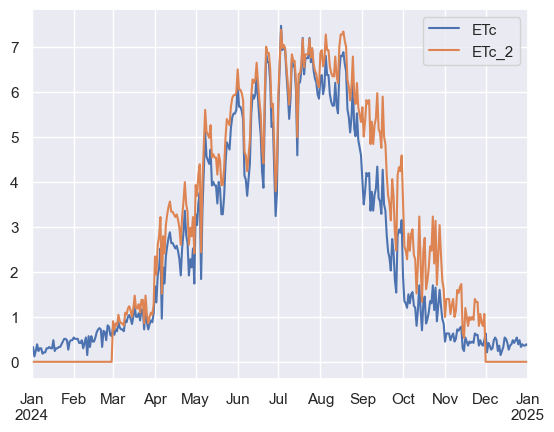

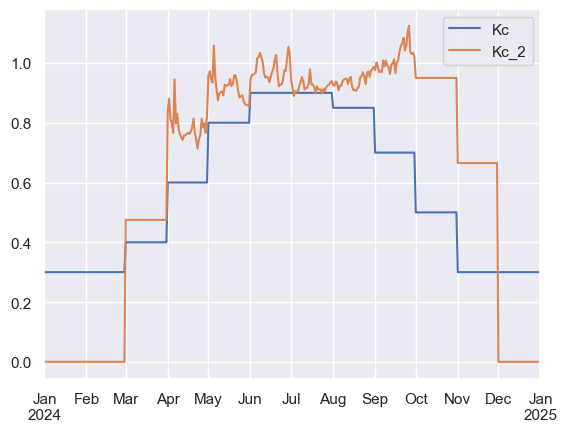

In [33]:
# Are there big differences?
df_merged['Kc_2'] = df_merged['Kt'] + df_merged['Kg'] + df_merged['Ks']

df_merged['2024-01-01':'2025-01-01'][['ETc', 'ETc_2']].plot()

df_merged['2024-01-01':'2025-01-01'][['Kc', 'Kc_2']].plot()

## Field level irrigation requirements and evapotranspiration

We now demonstrated how to get to maximum crop evaporation (or potential evaporation) specifically for Almonds. Finally, to measure the actual evapotranspiration you need to correct for the crop stress to estimate what is truly transpired on a day or during a growing season. However, for this exercise it is already interesting to calculate the ETc-Precipitation and compare it to the irrigation quota to get an estimate of the irrigation requirements and whether they met crop water demand to sustain maximum almond cultivation. And, of course, to get a feel if the current application rates and hydrological context are suitable to intensive almond production.



In [64]:
# water deficit:
df_merged['Irrigation requirement'] = df_merged['ETc'] - df_merged['Precip']

df_merged['Irrigation requirement'][df_merged['Irrigation requirement']<0] = 0
print(df_merged.head())

            ETref    Precip      NDVI   Kc   ETc  Irrigation requirement
2018-01-01    0.6   0.00000  0.203622  0.3  0.18                    0.18
2018-01-02    0.6   0.00000  0.206655  0.3  0.18                    0.18
2018-01-03    0.7   0.00000  0.209688  0.3  0.21                    0.21
2018-01-04    0.6  14.90844  0.212722  0.3  0.18                    0.00
2018-01-05    0.6   0.00000  0.215755  0.3  0.18                    0.18


C:\Users\ici-1\AppData\Local\Temp\ipykernel_13980\2941941847.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_merged['Irrigation requirement'][df_merged['Irrigation requirement']<0] = 0


In [65]:
df_merged['2022-01-01':'2022-12-31'].sum()

ETref                     1402.200000
Precip                     789.874229
NDVI                       135.539456
Kc                         208.950000
ETc                        982.665000
Irrigation requirement     930.739178
dtype: float64

       ETref      Precip        NDVI      Kc       ETc  \
year                                                     
2018  1204.8  822.138323   94.403365  208.95   857.395   
2019  1357.3  589.891532  105.781049  208.95   960.390   
2020  1332.1  816.661684  175.501365  209.25   941.400   
2021  1355.4  631.388915  190.019055  208.95   949.110   
2022  1402.2  789.874229  135.539456  208.95   982.665   
2023  1450.1  623.845733  124.284762  208.95  1026.155   
2024  1353.5  642.282514  127.042824  209.25   955.595   
2025     1.2    0.000000    0.264528    0.30     0.360   

      Irrigation requirement  month  
year                                 
2018              799.395307   2382  
2019              900.382312   2382  
2020              865.263936   2384  
2021              874.669930   2382  
2022              930.739178   2382  
2023              973.655000   2382  
2024              899.071078   2384  
2025                0.360000      1  


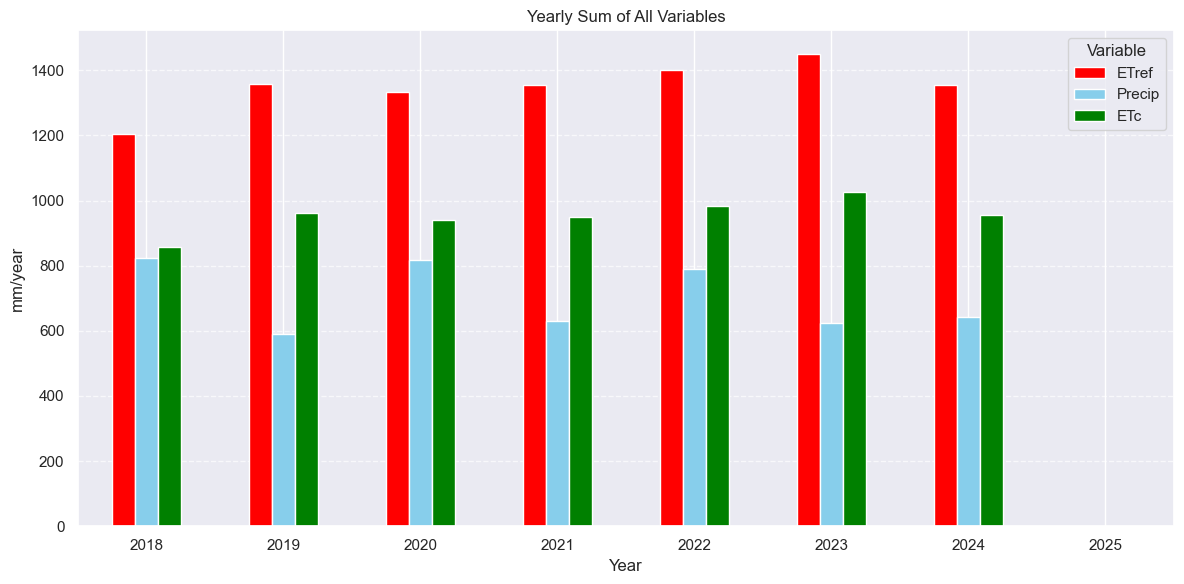

In [75]:
df_merged['year'] = df_merged.index.year
df_merged['month'] = df_merged.index.month

# Group by year and sum all other columns
yearly_sum = df_merged.groupby('year').sum(numeric_only=True)

# Drop 'year' column if it was included (can happen with some settings)
if 'year' in yearly_sum.columns:
    yearly_sum = yearly_sum.drop(columns=['year'])

print(yearly_sum)
# Plot
ax = yearly_sum[['ETref', 'Precip', 'ETc']].plot(kind='bar', figsize=(12, 6), color=['red', 'skyblue', 'green'])

plt.title('Yearly Sum of All Variables')
plt.xlabel('Year')
plt.ylabel('mm/year')
plt.xticks(rotation=0)
plt.legend(title='Variable')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

From the above graph we can see rainfall is not sufficient to meet maximum Almond Evapotranspiration

   year   ETref      Precip        NDVI      Kc      ETc  \
0  2018  1067.0  545.594551   60.517942  172.95  816.055   
1  2019  1204.4  256.035674   40.938826  172.95  914.520   
2  2020  1165.7  514.004143  112.036775  172.95  891.480   
3  2021  1183.7  380.992369  134.141658  172.95  897.600   
4  2022  1209.9  424.728669   94.161688  172.95  924.975   
5  2023  1282.2  401.216579   86.578856  172.95  975.785   
6  2024  1175.7  405.426155   91.752046  172.95  902.255   

   Irrigation requirement  month  
0              762.318553   1593  
1              860.817417   1593  
2              822.453936   1593  
3              830.059930   1593  
4              881.779178   1593  
5              930.455000   1593  
6              851.311078   1593  
[192.31855292 290.81741745 252.45393641 260.05993014 311.77917821
 360.455      281.31107831]
[570. 570. 570. 570. 570. 570. 570.]


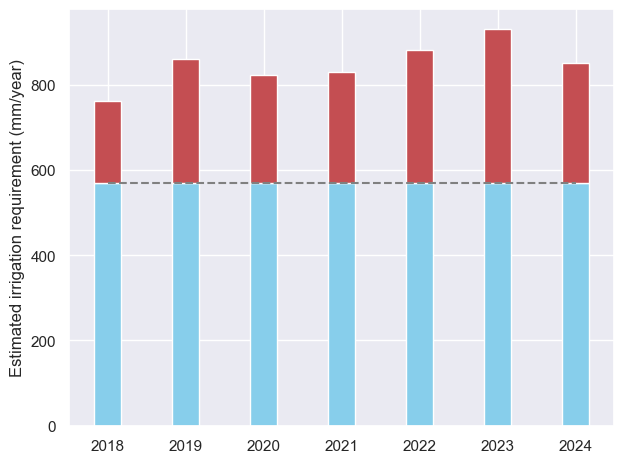

In [74]:
# Filter for months March (3) to September (9)
df_filtered = df_merged[(df_merged['month'] >= 3) & (df_merged['month'] <= 10)]

# Group by year and sum values
yearly_sums = df_filtered.groupby('year').sum().reset_index()

print(yearly_sums)

# some example data
threshold = 570 #mm/year irrigation requirement

# split it up
above_threshold = np.maximum(yearly_sums['Irrigation requirement'].values - threshold, 0)
below_threshold = np.minimum(yearly_sums['Irrigation requirement'].values, threshold)

print(above_threshold)
print(below_threshold)


# and plot it
fig, ax = plt.subplots()
ax.bar(yearly_sums['year'].values, below_threshold, 0.35, color="skyblue")
ax.bar(yearly_sums['year'].values, above_threshold, 0.35, color="r",
        bottom=below_threshold)

# horizontal line indicating the threshold
ax.plot([yearly_sums['year'].min(), yearly_sums['year'].max()], [threshold, threshold], color="gray", linestyle='--')

plt.ylabel('Estimated irrigation requirement (mm/year)')
plt.tight_layout()
plt.show()

## On the irrigation quota

* The irrigation quota is 570 mm/ year (1 hectare) for Alqueva, if we extrapolate this to to Idanha-a-Nova we can estimate that with the available irrigation it is not possible to meet maximum almond evapotranspiration.
* However, after a field visit to Idanha-a-Nova in May 2025 we know the irrigation quota is not being controlled due to a outdated irrigation system and absence of flow meters in the system. The bigger orchards actually maintain a trackrecord on how much irrigation water they use and have installed several flow meters at the inlet of their fields. 
* Almond farmers in Idanha-a-Nova have almost unlimited access to water and, therefore, water stress is not their biggest production issue at the moment
* The estimated irrigation requirement to meet maximum almond evapotranspiration is around 800 mm/year during the growing season (March-September)
* Sustainable water management or conservation management is of highest priority on field and basin level
* On irrigation techniques: All almond orchards we visited in Idanha-a-Nova used drip irrigation


## Actual crop evapotranspiration

To calculate the actual evapotranspiration we need to correct for crop stress to indicate how much water is actually evaporated (also an indication if irrigation is applied). There are multiple ways to include crop stress: by looking at the vegetation stress, or incorporating a rootzone water balance, or to get ETa directly from a energy balance model (e.g. SEBAL). For now we focus on calculating a stress factor on optical signals. 

C:\Users\ici-1\AppData\Local\Temp\ipykernel_4292\641371869.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_apr_oct = df_merged.loc['2021-01-01':'2025-01-01'][(df_merged['Month'] >= 4) & (df_merged['Month'] < 10)]


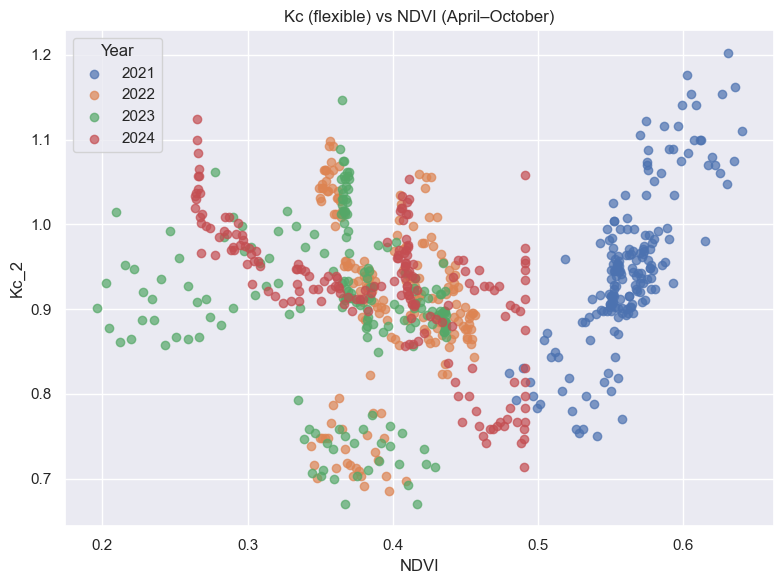

In [45]:
# Filter for April (4) to October (10)
df_apr_oct = df_merged.loc['2021-01-01':'2025-01-01'][(df_merged['Month'] >= 4) & (df_merged['Month'] < 10)]

# Plot grouped by Year
fig, ax = plt.subplots(figsize=(8, 6))

for year, group in df_apr_oct.groupby('Year'):
    ax.scatter(group['NDVI'], group['Kc_2'], label=str(year), alpha=0.7)

ax.set_xlabel('NDVI')
ax.set_ylabel('Kc_2')
ax.set_title('Kc (flexible) vs NDVI (April–October)')
ax.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

## Interesting articles

#### Agronomic response, transpiration and water productivity of four almond production systems under different irrigation regimes
* In Spain, irrigated almond has become more popular during recent decades, rising from 4.7 % of cultivated land in 2005 to 26 % in 2023 (180,562 ha)
* In the particular case of the Segarra-Garrigues (Lleida, Spain) irrigation district, water rights for almonds in 2023 were established at 1350 m3 ha−1, which corresponded to a water restriction of around 80 % (6500 m3 ha−1 in full water allocation conditions) (ASG, 2023).

#### Establishing an almond water production function for California using long‑term yield response to variable irrigation

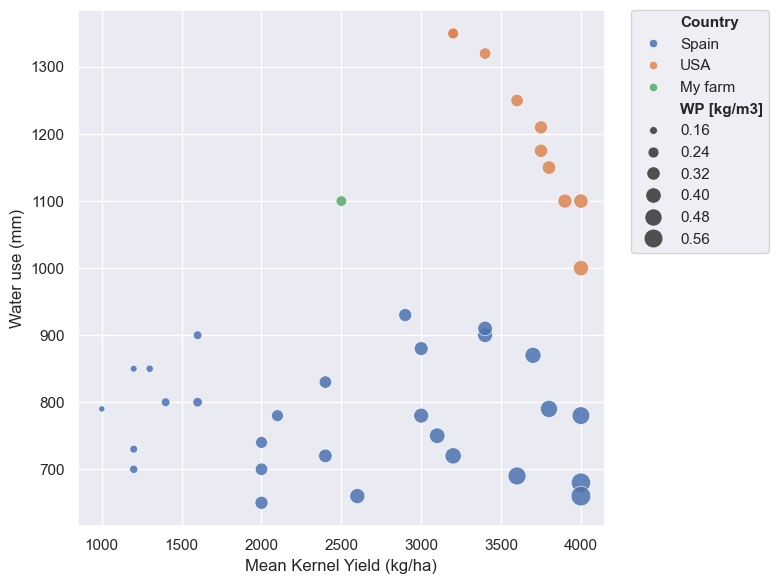

In [19]:
df_wp = pd.read_csv(os.path.join('Data\\WP\\','wp_almond.csv'), index_col=0, header=0)

sns.set_theme()


# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
plot = sns.scatterplot(
    data=df_wp,
    x="Mean Kernel Yield (kg/ha)",
    y="Water use (mm)",
    hue="Country",
    size="WP [kg/m3]",
    sizes=(20, 200),
    alpha=0.85,
    ax=ax
)

# Move the legend outside the plot (right side)
legend = ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0
)

# Bold the legend subtitles
for text in legend.get_texts():
    if text.get_text() in ["Country", "WP [kg/m3]"]:
        text.set_weight("bold")

plt.tight_layout()
plt.show()

## How to continue with Orchard Water Use?

* A first rough field level water use estimate is viable with the data available
* Get clean field-level vegetation signals
* We can also create spatial ET maps if need be
* Future work: correct for Canopy Cover (fraction) and moisture stress --> tree spacing is 6 x 4m on average (see ppt Portugal Nuts)
* Explore thermal products (Especially if in cover crops thermal data will be included in analysis)
* Idea to add: Water Productivity graph
* Get field level irrigation and ET data (weather station) or sm probes (to validate moisture stress)
* delve into literature on deficit irrigation and almond production: what are the numbers